In [1]:
from configparser import ConfigParser
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from collections import Counter 
import datetime
import pickle
import time
import os


from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [2]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql_sample.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [3]:
cfg = config()

In [4]:
#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(**cfg)
#     conn = psycopg2.connect(
#         host="www.eecs.uottawa.ca",
#         database="group_22",
#         user="yzhao156",
#         password="UozonePassword",
#         port=15432
#     )
    cursor = conn.cursor()
    print("Look's like it was a success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [5]:
try:
    #Lets get our data 
    cursor.execute(
    """
SELECT D.month as month,  S.title as special_measure, 
    P.Age_Group as Age_Group, P.client_gender as gender, 
    M.parks_percent_change_from_baseline as mobility,
    F.resolved as resolved
FROM covid19_tracking_fact_table F, 
    date_dimension D, 
    mobility_dimension M,
    special_measures_dimension S,
    patient_dimension P
WHERE F.reported_date_key = D.surrogate_key AND
    F.special_measure_key = S.surrogate_key AND
    F.mobility_key = M.surrogate_key AND
    F.patient_key = P.surrogate_key 
ORDER BY D.date
    """    
        
                  
    
    )

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [6]:
cursor.close()
conn.close()

In [8]:
data = pd.DataFrame(result_list,columns=["month", "special_measure",
                "Age_Group", "gender", "mobility", "resolved"])

In [11]:
data.head()

,month,special_measure,Age_Group,gender,mobility,resolved
0,11,Restrict,40s,MALE,-26.0,1
1,11,Restrict,30s,MALE,-26.0,1
2,11,Restrict,50s,MALE,-26.0,1
3,11,Restrict,<20,FEMALE,-26.0,1
4,11,Restrict,30s,FEMALE,-26.0,1


In [12]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( data, open( "./saves/data.p", "wb" ) )

In [2]:
data = pickle.load( open( "./saves/data.p", "rb" ) )

In [32]:
data

,month,special_measure,Age_Group,gender,mobility,resolved
0,11,Restrict,40s,MALE,-26.0,1
1,11,Restrict,30s,MALE,-26.0,1
2,11,Restrict,50s,MALE,-26.0,1
3,11,Restrict,<20,FEMALE,-26.0,1
4,11,Restrict,30s,FEMALE,-26.0,1
...,...,...,...,...,...,...
147899,2,Control,<20,FEMALE,-23.0,0
147900,2,Control,20s,MALE,-23.0,0
147901,2,Control,20s,FEMALE,-23.0,0
147902,2,Control,50s,FEMALE,-23.0,1


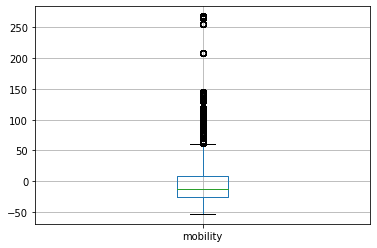

In [14]:
data.boxplot(column=['mobility'])

(array([6.49280013e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.20857974e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.59857445e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.63944180e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.27057791e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.08883841e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.40391365e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.98356892e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.54543488e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.60594259e-04]),
 array([0.   , 0.225, 0.45 , 0.675, 0.9  , 1.125, 1.35 , 1.575, 1.8  ,
        2.025, 2.25 , 2.475, 2.7  , 2.925, 3.15 , 3.375, 3.6  , 3.825,
        4.05 , 4.275, 4.5  , 4.725, 4.95 , 5.175, 5.4  , 5.625, 5.85 ,
        6.075, 6.3  , 6.525, 6.75 , 6.975, 7.2  , 7.425, 7.65 , 7

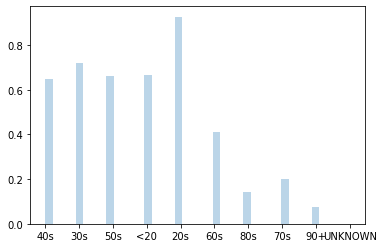

In [15]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
plt.hist(data['Age_Group'], **kwargs)

# A.2

In [16]:
data.head()

,month,special_measure,Age_Group,gender,mobility,resolved
0,11,Restrict,40s,MALE,-26.0,1
1,11,Restrict,30s,MALE,-26.0,1
2,11,Restrict,50s,MALE,-26.0,1
3,11,Restrict,<20,FEMALE,-26.0,1
4,11,Restrict,30s,FEMALE,-26.0,1


In [3]:
data.isna().sum()

month              0
special_measure    0
Age_Group          0
gender             0
mobility           0
resolved           0
dtype: int64

In [4]:
data = data[data['Age_Group']!="UNKNOWN"]

In [5]:
data['Age_Group'].drop_duplicates()

0      40s
1      30s
2      50s
3      <20
7      20s
11     60s
37     80s
44     70s
518    90+
Name: Age_Group, dtype: object

In [6]:
mapping_age = {
    '<20':0,
    '20s':1,
    '30s':2,
    '40s':3,
    '50s':4,
    '60s':5,
    '70s':6,
    '80s':7,
    '90+':8
}
data['Age_Group'] = data['Age_Group'].map(lambda x : mapping_age[x])
    

In [7]:
mapping_month = {
    11:1,
    12:2,
    1:3,
    2:4
}
data['month'] = data['month'].map(lambda x : mapping_month[x])

In [8]:
mapping_gender = {
    'MALE':0,
    'FEMALE':1,
    'UNSPECIFIED':2,
    'GENDER DIVERSE':3
}
data['gender'] = data['gender'].map(lambda x : mapping_gender[x])


In [9]:
one_hot = pd.get_dummies(data.special_measure, prefix='special_measure')
one_hot.shape

(147892, 5)

In [10]:
data.shape

(147892, 6)

In [11]:
data = pd.concat([data,one_hot],axis=1)

In [13]:
data = data.drop(columns=['special_measure'])

In [14]:
data

,month,Age_Group,gender,mobility,resolved,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
0,1,3,0,-26.0,1,0,0,0,0,1
1,1,2,0,-26.0,1,0,0,0,0,1
2,1,4,0,-26.0,1,0,0,0,0,1
3,1,0,1,-26.0,1,0,0,0,0,1
4,1,2,1,-26.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
147899,4,0,1,-23.0,0,1,0,0,0,0
147900,4,1,0,-23.0,0,1,0,0,0,0
147901,4,1,1,-23.0,0,1,0,0,0,0
147902,4,4,1,-23.0,1,1,0,0,0,0


### normalisation

In [15]:
#normalize mobility
data['mobility'] = (data['mobility']-data['mobility'].min())/(data['mobility'].max()-data['mobility'].min())
data['Age_Group'] = (data['Age_Group']-data['Age_Group'].min())/(data['Age_Group'].max()-data['Age_Group'].min())
data['month'] = (data['month']-data['month'].min())/(data['month'].max()-data['month'].min())

In [16]:
data

,month,Age_Group,gender,mobility,resolved,special_measure_Control,special_measure_Lockdown,special_measure_Prevent,special_measure_Protect,special_measure_Restrict
0,0.0,0.375,0,0.084112,1,0,0,0,0,1
1,0.0,0.250,0,0.084112,1,0,0,0,0,1
2,0.0,0.500,0,0.084112,1,0,0,0,0,1
3,0.0,0.000,1,0.084112,1,0,0,0,0,1
4,0.0,0.250,1,0.084112,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
147899,1.0,0.000,1,0.093458,0,1,0,0,0,0
147900,1.0,0.125,0,0.093458,0,1,0,0,0,0
147901,1.0,0.125,1,0.093458,0,1,0,0,0,0
147902,1.0,0.500,1,0.093458,1,1,0,0,0,0


In [17]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( data, open( "./saves/prereocessed_data.p", "wb" ) )

In [11]:
data = pickle.load( open( "./saves/prereocessed_data.p", "rb" ) )

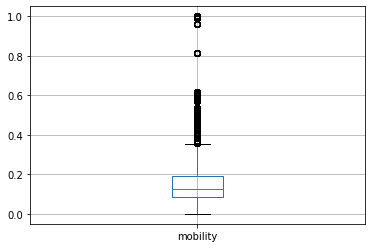

In [12]:
data.boxplot(column=['mobility'])

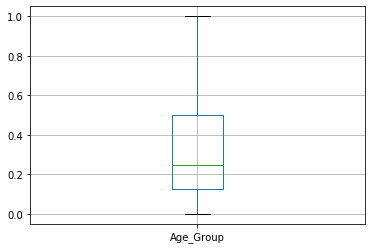

In [13]:
data.boxplot(column=['Age_Group'])

### undersampling

In [14]:
shuffle_unresolved = shuffle(data[data['resolved']==0])
shuffle_resolved = shuffle(data[data['resolved']==1])
shuffle_resolved = shuffle_resolved[:len(shuffle_unresolved)]
undersampled_data = shuffle_resolved.append(shuffle_unresolved)
undersampled_data = shuffle(undersampled_data)

In [15]:
len(undersampled_data)

11944

In [16]:
if not os.path.exists('saves'):
    os.makedirs('saves')
pickle.dump( undersampled_data, open( "./saves/undersampled_data.p", "wb" ) )

# Part B

## Decision Tree

In [3]:
undersampled_data = pickle.load( open( "./saves/undersampled_data.p", "rb" ) )

In [4]:
data = pickle.load( open( "./saves/undersampled_data.p", "rb" ) )

In [5]:
column_list = data.columns.values.tolist()
column_list.remove('resolved')

In [6]:
column_list

['month',
 'Age_Group',
 'gender',
 'mobility',
 'special_measure_Control',
 'special_measure_Lockdown',
 'special_measure_Prevent',
 'special_measure_Protect',
 'special_measure_Restrict']

In [7]:
iris = load_iris()
X = undersampled_data[column_list]
y = undersampled_data['resolved']
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(X, y)
r = export_text(decision_tree, feature_names=column_list)

In [8]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(X, y)
r = export_text(decision_tree, feature_names=column_list)

In [9]:
print(r)

|--- month <= 0.83
|   |--- Age_Group <= 0.69
|   |   |--- class: 1
|   |--- Age_Group >  0.69
|   |   |--- class: 0
|--- month >  0.83
|   |--- mobility <= 0.08
|   |   |--- class: 0
|   |--- mobility >  0.08
|   |   |--- class: 0



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [11]:
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({0: 4778, 1: 4777}) 
Test set Counter({1: 1195, 0: 1194}) 


In [12]:
start = time.time()
dt = DecisionTreeClassifier(criterion='entropy')
decision_tree = dt.fit(X_train, y_train)
time_took = time.time()-start

In [13]:
y_pred = dt.predict(X_test)
recall = recall_score(y_pred, y_test) * 100
precision = precision_score(y_pred, y_test) * 100
print("Recall of Decision Tree {:.2f} %".format(recall))
print("precision of Decision Tree {:.2f} %".format(precision))
print("Time to Train {:.2f} s".format(time_took))

Recall of Decision Tree 92.23 %
precision of Decision Tree 86.44 %
Time to Train 0.02 s


In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred,y_test)

0.895772289660946

In [15]:
r = export_text(decision_tree, feature_names=column_list)

In [16]:
# print(r)

In [17]:
####

In [18]:
column_list = data.columns.values.tolist()
column_list.remove('resolved')
column_list

['month',
 'Age_Group',
 'gender',
 'mobility',
 'special_measure_Control',
 'special_measure_Lockdown',
 'special_measure_Prevent',
 'special_measure_Protect',
 'special_measure_Restrict']

In [19]:
# split the train and test data
X = undersampled_data[column_list]
y = undersampled_data['resolved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

|--- month <= 0.83
|   |--- Age_Group <= 0.69
|   |   |--- class: 1
|   |--- Age_Group >  0.69
|   |   |--- class: 0
|--- month >  0.83
|   |--- class: 0



[Text(200.88000000000002, 181.2, 'X[0] <= 0.833\nentropy = 1.0\nsamples = 8958\nvalue = [4479.0, 4479.0]'),
 Text(133.92000000000002, 108.72, 'X[1] <= 0.688\nentropy = 0.816\nsamples = 5274\nvalue = [1333.871, 3932.586]'),
 Text(66.96000000000001, 36.23999999999998, 'entropy = 0.286\nsamples = 3806\nvalue = [189.55, 3606.532]'),
 Text(200.88000000000002, 36.23999999999998, 'entropy = 0.763\nsamples = 1468\nvalue = [1144.321, 326.054]'),
 Text(267.84000000000003, 108.72, 'entropy = 0.605\nsamples = 3684\nvalue = [3145.129, 546.414]')]

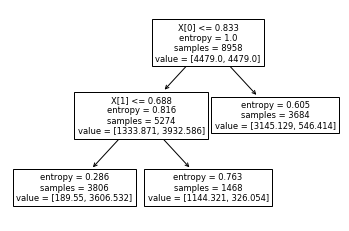

In [20]:
#Train the data
decision_tree = DecisionTreeClassifier(class_weight='balanced',criterion='entropy',max_depth=4,
            max_features=None,max_leaf_nodes=3,min_impurity_decrease=1e-04,min_samples_leaf=1,
            min_samples_split=2,min_weight_fraction_leaf=0.0,random_state=0,splitter='best')
start = time.time()
decision_tree = decision_tree.fit(X_train, y_train)
time_took = time.time()-start
#show the decision condiction and the structure of the tree
final_condiction= export_text(decision_tree, feature_names=column_list)
print(final_condiction)
tree.plot_tree(decision_tree) 

In [21]:
#eveulate the result
y_pred_tree=decision_tree.predict(X_test)
print (confusion_matrix(y_test,y_pred_tree))
print(classification_report(y_test,y_pred_tree))
print("Time to Train {:.2f} s".format(time_took))

[[1442   64]
 [ 305 1175]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1506
           1       0.95      0.79      0.86      1480

    accuracy                           0.88      2986
   macro avg       0.89      0.88      0.88      2986
weighted avg       0.89      0.88      0.88      2986

Time to Train 0.01 s


 ## Gradient Boosting  

 ## Random Forest

In [22]:
#training part
randomForest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', max_depth=4, random_state=0,
                                      max_features='sqrt',max_leaf_nodes=3,min_impurity_decrease=1e-04,
                                      min_samples_leaf=1,min_samples_split=2)
start = time.time()
randomForest.fit(X_train,y_train)
time_took = time.time()-start
#show the decision condiction and the structure of the tree

#Estimators = classifier.estimators_
#for index, model in enumerate(Estimators):
    #each_condiction= export_text(model, feature_names=['Age_Group', 'Client_Gender', 'mobility', 'Special_Measures_Control', 'Special_Measures_Lockdown', 'Special_Measures_Protect', 'Special_Measures_Restrict'])
    #print(each_condiction)


In [23]:
#eveulate the result
y_pred_forest = randomForest.predict(X_test)
print (confusion_matrix(y_test,y_pred_forest))
print(classification_report(y_test,y_pred_forest))

[[1360  146]
 [ 246 1234]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1506
           1       0.89      0.83      0.86      1480

    accuracy                           0.87      2986
   macro avg       0.87      0.87      0.87      2986
weighted avg       0.87      0.87      0.87      2986



In [24]:
#find the best learning rate
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
best_rate=lr_list[0]
best_accuracy=0
for learning_rate in lr_list:
    gradientBoosting = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gradientBoosting.fit(X_train, y_train)
    if gradientBoosting.score(X_test, y_test)>best_accuracy:
        best_accuracy=gradientBoosting.score(X_test, y_test)
        best_rate=learning_rate

In [25]:
#Using the best learning rate to train the model
gradientBoosting = GradientBoostingClassifier(n_estimators=20, learning_rate=best_accuracy, max_features=2, max_depth=2, random_state=0)
gradientBoosting.fit(X_train, y_train)

#eveulate the result
y_pred_boosting = gradientBoosting.predict(X_test)
print (confusion_matrix(y_test,y_pred_boosting))
print(classification_report(y_test,y_pred_boosting))
print("Time to Train {:.2f} s".format(time_took))

[[1409   97]
 [ 207 1273]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1506
           1       0.93      0.86      0.89      1480

    accuracy                           0.90      2986
   macro avg       0.90      0.90      0.90      2986
weighted avg       0.90      0.90      0.90      2986

Time to Train 0.04 s


 ## SVM
 

In [26]:
from sklearn import svm
clf_svm = svm.SVC(kernel="linear", random_state=0, max_iter=3500).fit(X_train, y_train)  

#eveulate the result
y_pred_svm = clf_svm.predict(X_test)
print (confusion_matrix(y_test,y_pred_svm))
print(classification_report(y_test,y_pred_svm))

[[1315  191]
 [ 412 1068]]
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1506
           1       0.85      0.72      0.78      1480

    accuracy                           0.80      2986
   macro avg       0.80      0.80      0.80      2986
weighted avg       0.80      0.80      0.80      2986



/Users/yi/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=3500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
